# Jesper's Exam Notebook & Ideas Log 

We start out by scraping two websites. Boligsiden.dk and jobnet.dk. The former contains information related to real estate, while the latter is a public website on which jobs are advertised. 

### Boligsiden
We use an API in the code below. To get around the maximum usage / upper limit (10000), we run a loop which exploits that we can take up to 10000 (200x50) of each real estate type. We store the data throughout, such that we are able to pick up the download again - and not have to start from scratch - if the scrape for some reason or other is interrupted. 

In [8]:
# We import standard stuff used in scraping
import requests
import tqdm
import time
import pandas as pd
import json
import os
import seaborn as sns

In [ ]:


property_types = [
    "villa", "condo", "terraced house", "holiday house", "cooperative",
    "farm", "hobby farm", "full year plot", "villa apartment", 
    "holiday plot", "houseboat"
]

# Load already completed pages if available
completed_pages_file = 'completed_pages.json'
completed_pages = {}

if os.path.exists(completed_pages_file):
    try:
        with open(completed_pages_file, 'r') as f:
            completed_pages = json.load(f)
            # Convert lists back to sets
            for key in completed_pages:
                completed_pages[key] = set(completed_pages[key])
    except json.JSONDecodeError:
        print(f"Warning: Could not decode JSON from {completed_pages_file}. Initializing a new empty dictionary.")

all_dataframes = []  # List to store DataFrames for each property type

for property_type in property_types:
    print(f"Scraping data for: {property_type}")
    property_links = []
    
    for page in range(1, 201):  # Iterate over the first 200 pages for each property type
        if completed_pages.get(property_type, set()).issuperset({page}):
            print(f"Skipping already downloaded page {page} for {property_type}")
            continue
        
        url = f'https://api.boligsiden.dk/search/cases?addressTypes={property_type.replace(" ", "%20")}&per_page=50&page={page}&sortAscending=true&sortBy=timeOnMarket'
        property_links.append((url, page))

    all_real_estate_postings = []  # To store all real estate postings for the current property type

    for url, page in tqdm.tqdm(property_links):
        try:
            response = requests.get(url, headers={'name': 'Jesper Petersen, Københavns Universitet, Studerende, email:kwf929@alumni.ku.dk'})
            response.raise_for_status()
        except Exception as e:
            print(url)  # Print URL
            print(e)  # Print error
            continue  # Continue to the next iteration of the loop

        result = response.json()
        real_estate_postings = result.get('cases', [])
        
        if real_estate_postings is None:
            print(f"Warning: Received 'None' for postings at page {page} for {property_type}")
            continue  # Skip this page if no data is retrieved
        
        all_real_estate_postings.extend(real_estate_postings)

        # Mark page as completed
        if property_type not in completed_pages:
            completed_pages[property_type] = set()
        completed_pages[property_type].add(page)

        # Convert sets to lists before saving to JSON
        completed_pages_to_save = {k: list(v) for k, v in completed_pages.items()}
        with open(completed_pages_file, 'w') as f:
            json.dump(completed_pages_to_save, f)
        
        time.sleep(0.5)  # To respect rate limits

    # Convert the collected data into a DataFrame
    df = pd.DataFrame(all_real_estate_postings)
    all_dataframes.append(df)  # Store the DataFrame

    # Save the individual DataFrame to a CSV file (optional)
    csv_filename = f'{property_type.replace(" ", "_")}_real_estate_postings.csv'
    df.to_csv(csv_filename, index=False)
    print(f"Data for {property_type} saved to {csv_filename}")

# Concatenate all the DataFrames into one
Final_Real_Estate_Postings = pd.concat(all_dataframes, ignore_index=True)

# Save the final concatenated DataFrame to a CSV file
final_csv_filename = 'final_real_estate_postings.csv'
Final_Real_Estate_Postings.to_csv(final_csv_filename, index=False)
print(f"All data saved to {final_csv_filename}")


Given the size of the dataset - and to be able to share it amongst group members, we save it as a csv file. The latter can then be called upon to create a dataframe in the subsequent analysis. 

In [44]:
csv = "final_real_estate_postings.csv"
df_real_estate = pd.read_csv(csv, low_memory=False)

pd.set_option('display.max.columns', 100)

df_real_estate

,_links,address,addressType,caseID,caseUrl,coordinates,daysOnMarket,defaultImage,descriptionBody,distinction,energyLabel,hasBalcony,hasElevator,hasTerrace,highlighted,housingArea,images,lotArea,monthlyExpense,numberOfBathrooms,numberOfFloors,numberOfRooms,numberOfToilets,pageViews,perAreaPrice,priceCash,priceChangePercentage,providerCaseID,realEstate,realtor,secondaryAddressType,slug,status,timeOnMarket,totalClickCount,totalFavourites,utilitiesConnectionFee,weightedArea,yearBuilt,descriptionTitle,nextOpenHouse,basementArea,cooperative
0,{'self': {'href': '/cases/76dec148-291c-4688-8...,{'_links': {'self': {'href': '/addresses/0a3f5...,villa,76dec148-291c-4688-8f16-1d5d8ec19be2,https://www.gravelstone.dk/redirect/?caseno=13...,"{'lat': 56.108833, 'lon': 10.037365, 'type': '...",0.0,"{'imageSources': [{'size': {'height': 80, 'wid...",Indflytningsklar villa med plads til:2 familie...,real_estate,c,False,False,False,False,286.0,"[{'imageSources': [{'size': {'height': 80, 'wi...",8535.0,3680.0,2.0,2.0,7.0,2.0,0.0,13564.0,4495000.0,0.00,130600005451306gra,{'downPayment': 25000},{'_links': {'self': {'href': '/realtors/46687e...,farm,torshoejvej-69-8362-hoerning-07518690__69_______,open,"{'current': {'days': 0}, 'total': {'days': 768...",0.0,0.0,{'includedInPrice': None},331.40,1800.0,NaN,NaN,NaN,NaN
1,{'self': {'href': '/cases/8898110b-c723-4a08-b...,{'_links': {'self': {'href': '/addresses/0a3f5...,villa,8898110b-c723-4a08-b1db-acfc9cf40f0c,https://home.dk/sag/8050001010,"{'lat': 57.715256, 'lon': 10.5659485, 'type': ...",0.0,"{'imageSources': [{'size': {'height': 80, 'wid...",Velkommen til Fredensklit 5A - en velbeliggend...,real_estate,e,False,False,False,False,106.0,"[{'imageSources': [{'size': {'height': 80, 'wi...",377.0,3775.0,2.0,1.0,4.0,2.0,0.0,50137.0,5495000.0,0.00,8050001010805hom,"{'downPayment': 275000, 'grossMortgage': 31149...",{'_links': {'self': {'href': '/realtors/da4fb6...,holiday house,fredensklit-5a-9990-skagen-08130441__5a_______,open,"{'current': {'days': 0}, 'total': {'days': 0, ...",0.0,0.0,{'includedInPrice': None},109.60,1981.0,VESTERBY OG DAMSTEDERNE NÅR DET ER BEDST - FLO...,NaN,NaN,NaN
2,{'self': {'href': '/cases/2ab07608-2160-4d34-9...,{'_links': {'self': {'href': '/addresses/0a3f5...,villa,2ab07608-2160-4d34-95c5-a858d5f7dd78,https://johnfrandsen.dk/sag/35840000813/roersa...,"{'lat': 56.27646, 'lon': 10.057582, 'type': 'E...",0.0,"{'imageSources': [{'size': {'height': 80, 'wid...",ATTRAKTIVT RÆKKEHUS I HH-OMRÅDETPå Rørsangerve...,real_estate,c,False,False,False,False,95.0,"[{'imageSources': [{'size': {'height': 80, 'wi...",259.0,2118.0,1.0,1.0,4.0,1.0,2.0,23635.0,2295000.0,0.00,358400008133584joh,"{'downPayment': 115000, 'grossMortgage': 13097...",{'_links': {'self': {'href': '/realtors/f5c76e...,NaN,roersangervej-62-8382-hinnerup-07100836__62___...,open,"{'current': {'days': 0}, 'total': {'days': 0, ...",1.0,0.0,{'includedInPrice': None},97.10,1989.0,ATTRAKTIVT RÆKKEHUS I HH-OMRÅDET,"{'date': '2024-08-15T13:30:00Z', 'duration': 4...",NaN,NaN
3,{'self': {'href': '/cases/fcc666bf-77df-4233-8...,{'_links': {'self': {'href': '/addresses/0a3f5...,villa,fcc666bf-77df-4233-813a-85f396d2f3bf,https://www.tanjamathiesen.dk/sag/1950000229,"{'lat': 55.35005, 'lon': 12.323761, 'type': 'E...",0.0,"{'imageSources': [{'size': {'height': 80, 'wid...","Gammel Køgevej 27, KlippingeIdyl i Klippinge m...",real_estate,f,False,False,False,False,214.0,"[{'imageSources': [{'size': {'height': 80, 'wi...",970.0,1948.0,1.0,1.0,6.0,2.0,4.0,6215.0,1375000.0,0.00,1950000229195tan,"{'downPayment': 70000, 'grossMortgage': 7997, ...",{'_links': {'self': {'href': '/realtors/04265b...,NaN,gammel-koegevej-27-4672-klippinge-03360413__27...,open,"{'current': {'days': 0}, 'total': {'days': 0, ...",1.0,0.0,{'includedInPrice': None},221.25,1800.0,"Gammel Køgevej 27, KlippingeIdyl I Klippinge m...",NaN,NaN,NaN
4,{'self': {'href': '/cases/56a975da-97d8-4e52-8...,{'_links': {'self': {'href': '/addresses/cc125...,villa,56a975da-97d8-4e52-825c-46

## Jobnet
Here we perform a "standard" scrape. The code looks much that that practiced in Excercise 6. We encounter no limits and are able to run the scrape code without problems. Once again we save data throughout, to make the code robust. As in the first scrape, we're transparent in our requests - and signal clearly that we are students. 

In [ ]:
import requests
import tqdm
import time
import pandas as pd
import json
import os


# Define the log function to gather the log information
def log(response,logfile,output_path=os.getcwd()):
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to new line




# Load already completed pages if available
completed_pages_file = 'completed_job_pages.json'
completed_pages = set()

if os.path.exists(completed_pages_file):
    try:
        with open(completed_pages_file, 'r') as f:
            completed_pages = set(json.load(f))
    except json.JSONDecodeError:
        print(f"Warning: Could not decode JSON from {completed_pages_file}. Initializing an empty set.")

links = []
for page in range(0, 17992, 20):
    if page in completed_pages:
        print(f"Skipping already downloaded page {page}")
        continue
    url = f'https://job.jobnet.dk/CV/FindWork/Search?Offset={page}'
    links.append(url)

list_htmls = []
logfile = 'log3.csv'
all_job_postings = []  # To store all job postings

for url in tqdm.tqdm(links):
    try:
        response = requests.get(url, headers={'name': 'Jesper Petersen, Københavns Universitet, Studerende, email:kwf929@alumni.ku.dk'})
        response.raise_for_status()
    except Exception as e:
        print(url)  # Print URL
        print(e)  # Print error
        with open("list_htmls.json", "w") as l:  # Save the list_htmls as a JSON file to retrieve at another time
            json.dump(list_htmls, l)
        continue  # Continue to next iteration of the loop

    result = response.json()
    job_position_postings = result.get('JobPositionPostings', [])
    all_job_postings.extend(job_position_postings)

    # Mark page as completed
    completed_pages.add(page)

    # Save the updated completed pages to the JSON file
    with open(completed_pages_file, 'w') as f:
        json.dump(list(completed_pages), f)

    time.sleep(0.5)
    log(response, logfile)

    # Save the collected data incrementally to avoid losing it
    Job_Position_Postings = pd.DataFrame(all_job_postings)
    Job_Position_Postings.to_csv("job_postings_backup.csv", index=False)

# Save the final DataFrame to a CSV file
final_csv_filename = 'final_job_postings.csv'
Job_Position_Postings.to_csv(final_csv_filename, index=False)
print(f"All data saved to {final_csv_filename}")


As before, we call up the data in a Pandas dataframe. 

In [43]:
csv = "final_job_postings.csv"
df_jobs = pd.read_csv(csv, low_memory=False)

pd.set_option('display.max.columns', 100)

df_jobs

,AutomatchType,Abroad,Weight,Title,JobHeadline,Presentation,HiringOrgName,WorkPlaceAddress,WorkPlacePostalCode,WorkPlaceCity,WorkPlaceOtherAddress,WorkPlaceAbroad,WorkPlaceNotStatic,UseWorkPlaceAddressForJoblog,PostingCreated,LastDateApplication,FormattedLastDateApplication,AssignmentStartDate,IsHotjob,IsExternal,Url,Region,Municipality,Country,PostalCode,PostalCodeName,JobAnnouncementType,EmploymentType,WorkHours,OccupationArea,OccupationGroup,Occupation,Location,JoblogWorkTime,WorkplaceID,OrganisationId,HiringOrgCVR,UserLoggedIn,AnonymousEmployer,ShareUrl,DetailsUrl,JobLogUrl,HasLocationValues,ID,Latitude,Longitude
0,0,False,1.0,Social-og Sundhedsassistent søges i aftenvagt ...,Social-og Sundhedsassistent søges i aftenvagt ...,Vi tilbyder en arbejdsplads med dygtige kolleg...,Hedebo Rehabiliteringscenter,Degnestræde 1,2670.0,Greve,False,False,False,True,2024-08-15T00:00:00,2024-08-28T00:00:00,28. august 2024,0001-01-01T00:00:00,False,False,https://job.jobnet.dk/CV/FindWork/Details/6098326,Øvrige Sjælland,Greve,Danmark,2670.0,NaN,NaN,NaN,Fuldtid,"Sundhed, omsorg og personlig pleje",Pleje og omsorg,Social- og sundhedsassistent,"{'Latitude': 55.5943, 'Longitude': 12.2495}","{'WorkHour': None, 'DailyWorkTime': None}",117937,8913.0,44023911,False,False,https://job.jobnet.dk/CV/FindWork/DetailsSocia...,https://job.jobnet.dk/CV/FindWork/Details/6098326,https://job.jobnet.dk/CV/FindWork/Details/6098326,True,6098326,55.5943,12.2495
1,0,False,1.0,SSA og SSH aftenvagter til Distikt Klintholm,SSA og SSH aftenvagter til Distikt Klintholm,Har du lyst til at medvirke til at den enkelte...,Vordingborg Kommune,Sildemarken 2,4791.0,Borre,False,False,False,True,2024-08-15T00:00:00,2024-08-29T00:00:00,29. august 2024,0001-01-01T00:00:00,False,False,https://job.jobnet.dk/CV/FindWork/Details/6098324,Øvrige Sjælland,Vordingborg,Danmark,4791.0,NaN,NaN,NaN,Fuldtid,"Sundhed, omsorg og personlig pleje",Pleje og omsorg,Social- og sundhedsassistent,"{'Latitude': 54.9572, 'Longitude': 12.476}","{'WorkHour': None, 'DailyWorkTime': None}",60762,59119.0,29189676,False,False,https://job.jobnet.dk/CV/FindWork/DetailsSocia...,https://job.jobnet.dk/CV/FindWork/Details/6098324,https://job.jobnet.dk/CV/FindWork/Details/6098324,True,6098324,54.9572,12.4760
2,0,False,1.0,Dagplejepædagog til dagtilbud Område Tønder,Dagplejepædagog til dagtilbud Område Tønder,Vil du være med til at sikre og understøtte tr...,Tønder Kommune,Wegners Plads 2 1,6270.0,Tønder,False,False,False,True,2024-08-15T00:00:00,2024-08-26T00:00:00,26. august 2024,0001-01-01T00:00:00,False,False,https://job.jobnet.dk/CV/FindWork/Details/6098323,Syddanmark,Tønder,Danmark,6270.0,NaN,NaN,NaN,Fuldtid,"Pædagogisk, socialt og kirkeligt arbejde",Pædagogisk arbejde,Pædagog,"{'Latitude': 54.9325, 'Longitude': 8.8686}","{'WorkHour': None, 'DailyWorkTime': None}",60474,58050.0,29189781,False,False,https://job.jobnet.dk/CV/FindWork/DetailsSocia...,https://job.jobnet.dk/CV/FindWork/Details/6098323,https://job.jobnet.dk/CV/FindWork/Details/6098323,True,6098323,54.9325,8.8686
3,0,False,1.0,Mekaniker til certificeret værksted i Roskilde,Mekaniker til certificeret værksted i Roskilde,Kunne du tænke dig at arbejde med store maskin...,"Banedanmark, Carsten Niebuhrs Gade 43",Carsten Nieburhs Gade 43,1577.0,København V,False,False,False,True,2024-08-15T00:00:00,2024-09-13T00:00:00,13. september 2024,0001-01-01T00:00:00,False,False,https://job.jobnet.dk/CV/FindWork/Details/6098322,Hovedstaden og Bornholm,København,Danmark,1577.0,NaN,NaN,NaN,Fuldtid,"Jern, metal og auto","Mekanikerarbejde, transport",Automekaniker,"{'Latitude': 55.669, 'Longitude': 12.568}","{'WorkHour': None, 'DailyWorkTime': None}",25101,21944.0,18632276,False,False,https://job.jobnet.dk/CV/FindWork/DetailsSocia...,https://job.jobnet.dk/CV/FindWork/Details/6098322,https://job.jobnet.dk/CV/FindWork/Details/6098322,True,6098322,55.6690,12.5680
4,0,False,1.0,Økonomikonsulent til Sekretariatet i Borger & ...,Økonomikonsulent til Sekretariatet i Borger & ...

We like these two datasets together, given that they both contain information of addreses. We'll try to exploit that. Next, thefore, we'll attempt a first stab at building a distance calculator. 

## Distance

In [1]:
# We start out importing packages we suspect might come in handy. 

import osmnx as ox
import networkx as nx
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from tqdm import tqdm
import time
import threading

We suscpect that estimating "fugleflugt" is computationally easier, but also has the drawback that it is only an approximation. Best case, we are able to account for the *actual* distances that house buyers will face. We therefore want to import data for the Danish roads system. It's a rather large import so we wrap it in a function in an attempt to follow the progress of the download. It's a slightly tiresome download, which takes up to 400 seconds - on a standard personal computer + internet connection. 

In [2]:
# Wrapper function to show progress
def load_network_with_progress():
    print("Starting to load Denmark network...")
    start_time = time.time()
    
    # Initialize progress bar
    pbar = tqdm(total=100, desc="Loading network", bar_format='{l_bar}{bar} [ time: {elapsed} ]')

    # Function to update progress bar
    def update_progress():
        for i in range(100):
            time.sleep(1)  # Update every second
            pbar.update(1)
            if pbar.n >= 100:
                break

    # Start progress bar in a separate thread
    progress_thread = threading.Thread(target=update_progress)
    progress_thread.start()

    # Set the timeout using the settings module
    ox.settings.timeout = 300

    # Load Denmark network
    try:
        G = ox.graph_from_place("Denmark", network_type="drive")
    except Exception as e:
        print(f"An error occurred: {e}")
        pbar.close()
        progress_thread.join()
        return None

    pbar.n = 100  # Ensure progress bar reaches 100%
    pbar.refresh()
    pbar.close()
    progress_thread.join()
    
    end_time = time.time()
    print(f"Network loaded in {end_time - start_time:.2f} seconds")
    return G

# Use the function
G = load_network_with_progress()

if G is not None:
    print("Network loaded successfully")
else:
    print("Failed to load network")

Starting to load Denmark network...


Loading network: 100%|██████████████████████████████████████████ [ time: 06:35 ]

Network loaded in 395.08 seconds
Network loaded successfully


To test our imports we show an example. We define two points and measure the distance

The road distance is approximately 78.03 km


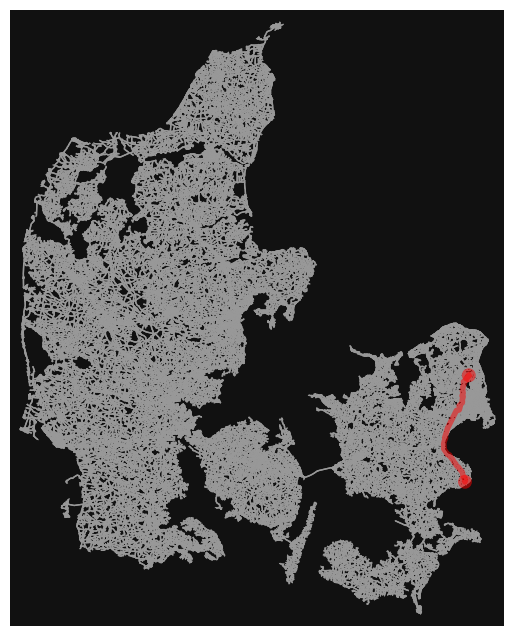

In [6]:
def get_nearest_node(lat, lon):
    return ox.nearest_nodes(G, lon, lat)

# Example coordinates (replace with your actual data)
origin = (55.847359, 12.428000)  # Birkerød
destination = (55.273930, 12.391680)  # Rødvig

# Get nearest nodes
origin_node = get_nearest_node(*origin)
dest_node = get_nearest_node(*destination)

route = nx.shortest_path(G, origin_node, dest_node, weight='length')

# Calculate total distance
distance = sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length'))

print(f"The road distance is approximately {distance/1000:.2f} km")

fig, ax = ox.plot_graph_route(G, route, route_color='r', route_linewidth=4, node_size=0)

## Different Solution 

Scaling the above appears computationally heavy. Say, we want to calculate distance between 35000 real estate addresses and 20000 job addresses, we need 700 million calculations. We try a different route. 

- Convert dataframes to GeoDataFrames for spatial operations. 

- Create a grid over Denmark.

- Calculate job density for each grid cell.

- Assign job density to each real estate listing based on its location.

- Calculate the distance to the nearest job center for each listing.


The benefits of this are as follows:
We achieve, in theory, something rather more computationally efficient: O(n log n) instead of O(n^2).
What we do is thus much more scalable: We are able to handle larger datasets.
We get a flexibility: We can adjust the grid size or use different spatial units (e.g., municipalities), which may prove to be the way forward. 

In [99]:
#!pip install geopy

import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from scipy.spatial import cKDTree
import ast
from shapely.geometry import box  
import matplotlib.pyplot as plt
from pyproj import Transformer
from geopy.distance import geodesic



### Extract coordinates and create GeoDataFrames
We start by exploiting that both dataframes have coordinates. The real estate data has to be parsed in order that we can create the GDF for the real estate listings. 

In [37]:
# Clean up coordinate data - and then create geometry column 

def parse_coordinates(coord):
    """Convert stringified dictionaries to actual dictionaries."""
    if isinstance(coord, str):
        try:
            # Safely evaluate the string to convert it to a dictionary
            return ast.literal_eval(coord)
        except (ValueError, SyntaxError):
            # Return None or handle the error as needed
            return None
    elif isinstance(coord, float):
        # Handle float values, which likely indicate missing data
        return None
    return coord

def create_gdf_real_estate(df):
    # Parse the 'coordinates' column
    df['coordinates'] = df['coordinates'].apply(parse_coordinates)

    # Filter out rows where coordinates could not be parsed correctly (i.e., None values)
    df = df[df['coordinates'].notnull()].copy()  # Use .copy() to avoid SettingWithCopyWarning
    
    # Extract lat and lon from the parsed 'coordinates' column
    df.loc[:, 'lat'] = df['coordinates'].apply(lambda x: x['lat'])
    df.loc[:, 'lon'] = df['coordinates'].apply(lambda x: x['lon'])
    
    # Create a geometry column from lon and lat
    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    
    # Return GeoDataFrame
    return gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")



def create_gdf_jobs(df):
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    return gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Create GeoDataFrames
real_estate_gdf = create_gdf_real_estate(df_real_estate)
job_listings_gdf = create_gdf_jobs(df_jobs)

#real_estate_gdf.head(1)
job_listings_gdf.head(1)


,AutomatchType,Abroad,Weight,Title,JobHeadline,Presentation,HiringOrgName,WorkPlaceAddress,WorkPlacePostalCode,WorkPlaceCity,WorkPlaceOtherAddress,WorkPlaceAbroad,WorkPlaceNotStatic,UseWorkPlaceAddressForJoblog,PostingCreated,LastDateApplication,FormattedLastDateApplication,AssignmentStartDate,IsHotjob,IsExternal,Url,Region,Municipality,Country,PostalCode,PostalCodeName,JobAnnouncementType,EmploymentType,WorkHours,OccupationArea,OccupationGroup,Occupation,Location,JoblogWorkTime,WorkplaceID,OrganisationId,HiringOrgCVR,UserLoggedIn,AnonymousEmployer,ShareUrl,DetailsUrl,JobLogUrl,HasLocationValues,ID,Latitude,Longitude,geometry
0,0,False,1.0,Social-og Sundhedsassistent søges i aftenvagt ...,Social-og Sundhedsassistent søges i aftenvagt ...,Vi tilbyder en arbejdsplads med dygtige kolleg...,Hedebo Rehabiliteringscenter,Degnestræde 1,2670.0,Greve,False,False,False,True,2024-08-15T00:00:00,2024-08-28T00:00:00,28. august 2024,0001-01-01T00:00:00,False,False,https://job.jobnet.dk/CV/FindWork/Details/6098326,Øvrige Sjælland,Greve,Danmark,2670.0,NaN,NaN,NaN,Fuldtid,"Sundhed, omsorg og personlig pleje",Pleje og omsorg,Social- og sundhedsassistent,"{'Latitude': 55.5943, 'Longitude': 12.2495}","{'WorkHour': None, 'DailyWorkTime': None}",117937,8913.0,44023911,False,False,https://job.jobnet.dk/CV/FindWork/DetailsSocia...,https://job.jobnet.dk/CV/FindWork/Details/6098326,https://job.jobnet.dk/CV/FindWork/Details/6098326,True,6098326,55.5943,12.2495,POINT (12.24950 55.59430)


## Creating a Grid 
We move on to "gridding": Our objective is to divide Denmark into grid cells. This reduces the problem from individual points to areas. Instead of O(n * m) where n is the number of houses and m is the number of jobs, this approach is closer to O(n log m) in average cases, which is much more efficient.

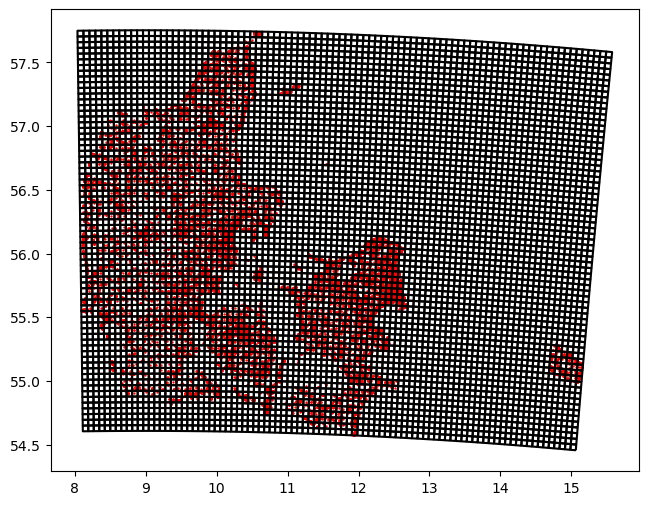

In [54]:
# 2. Create a grid ... we can adjust cell_size as needed, if we later find that it still is too 
#computationally intensive to run the operations we are interested in.


# Convert to a projected CRS (e.g., UTM zone 32N for Denmark)
real_estate_gdf_proj = real_estate_gdf.to_crs(epsg=25832)  # UTM zone 32N

# Create a grid in the projected CRS
denmark_bounds = real_estate_gdf_proj.total_bounds
cell_size = 5000  # 5km grid cells
x_min, y_min, x_max, y_max = denmark_bounds

grid_cells_proj = gpd.GeoDataFrame(
    geometry=[
        box(x, y, x + cell_size, y + cell_size)
        for x in np.arange(x_min, x_max, cell_size)
        for y in np.arange(y_min, y_max, cell_size)
    ],
    crs="EPSG:25832"  # Use the projected CRS
)

# Optionally convert the grid back to EPSG:4326 if needed
grid_cells = grid_cells_proj.to_crs(epsg=4326)

# Display the grid cells GeoDataFrame
grid_cells.head()


# Plot the grid
fig, ax = plt.subplots(figsize=(8, 6))
grid_cells.boundary.plot(ax=ax, color="black", markersize=.1)
real_estate_gdf.plot(ax=ax, color="red", markersize=.5)

plt.show()

In [57]:
# 3. Calculate job density for each grid cell


# Step 1: Perform spatial join
job_counts = gpd.sjoin(job_listings_gdf, grid_cells, how="inner", predicate="within")

# Step 2: Calculate job density
job_density = job_counts.groupby(job_counts.index_right).size().rename('job_density')

# Step 3: Ensure there's no existing 'job_density' column before joining
if 'job_density' in grid_cells.columns:
    grid_cells = grid_cells.drop(columns=['job_density'])

# Step 4: Join the job density with the grid cells
grid_cells = grid_cells.join(job_density, how='left')

# Step 5: Fill NaN values in the 'job_density' column with 0
grid_cells['job_density'] = grid_cells['job_density'].fillna(0)

# Display the result
print(grid_cells.head())


                                            geometry  job_density
0  POLYGON ((8.19148 54.60489, 8.19059 54.64982, ...          0.0
1  POLYGON ((8.19059 54.64982, 8.18970 54.69475, ...          0.0
2  POLYGON ((8.18970 54.69475, 8.18880 54.73968, ...          0.0
3  POLYGON ((8.18880 54.73968, 8.18790 54.78460, ...          0.0
4  POLYGON ((8.18790 54.78460, 8.18700 54.82953, ...          0.0


In [58]:
# 4. Spatial join to assign grid cell attributes to real estate listings
real_estate_with_density = gpd.sjoin(real_estate_gdf, grid_cells, how="left", op="within")


In [103]:
# 5. Calculate distance to nearest job center (works with centroids) 

def nearest_neighbor(point_gdf, centers_gdf, k=1):
    # Calculate centroids of the job center polygons
    centers_proj = centers_gdf.copy()
    centers_proj['geometry'] = centers_gdf.geometry.centroid
    
    # Project the geometries to a planar coordinate system (e.g., UTM)
    point_gdf_proj = point_gdf.to_crs(epsg=3395)  # WGS 84 / World Mercator
    centers_proj = centers_proj.to_crs(epsg=3395)
    
    # Extract the projected coordinates
    points = point_gdf_proj.geometry.apply(lambda geom: (geom.x, geom.y))
    centers = centers_proj.geometry.apply(lambda geom: (geom.x, geom.y))
    
    # Create cKDTree for the centers
    btree = cKDTree(centers.tolist())
    
    # Get the nearest neighbors and distances
    distances, indices = btree.query(points.tolist(), k=k)
    
    # Convert distances back to kilometers using the geodesic distance for accuracy
    km_distances = []
    for i, point in enumerate(point_gdf.geometry):
        nearest_center = centers_gdf.geometry.centroid.iloc[indices[i]]
        km_distance = geodesic((point.y, point.x), (nearest_center.y, nearest_center.x)).kilometers
        km_distances.append(km_distance)
    
    return np.array(km_distances)


#Older non-km version    
#def nearest_neighbor(point_gdf, centers_gdf, k=1):
#    # Calculate centroids of the job center polygons
#    centers = centers_gdf.geometry.centroid
#    btree = cKDTree([(p.x, p.y) for p in centers])
#    points = point_gdf.geometry
#    distances, _ = btree.query([(p.x, p.y) for p in points], k=k)
#    return distances

In [104]:
# 6. Define job centers (e.g., cells with job density > 90th percentile)

# Define job centers (e.g., cells with job density > 90th percentile)
job_centers = grid_cells[grid_cells['job_density'] > grid_cells['job_density'].quantile(0.9)]

# Calculate the distance to the nearest job center in kilometers
real_estate_with_density['distance_to_job_center'] = nearest_neighbor(real_estate_gdf, job_centers)



#job_centers = grid_cells[grid_cells['job_density'] > grid_cells['job_density'].quantile(0.9)]
#real_estate_with_density['distance_to_job_center'] = nearest_neighbor(real_estate_gdf, job_centers)

In [105]:
# 7. Adding more features 
real_estate_with_density['job_count_5km'] = gpd.sjoin_nearest(
    real_estate_gdf, 
    job_listings_gdf, 
    max_distance=5000
).groupby(level=0).size()

In [106]:
# 7. Prepare final dataset for machine learning
ml_dataset = real_estate_with_density[['priceCash', 'job_density', 'distance_to_job_center', 'job_count_5km']]


In [107]:
# Remove any rows with NaN values
ml_dataset = ml_dataset.dropna()

In [108]:
#print dataset 
pd.options.display.float_format = '{:.2f}'.format

#print(ml_dataset.head())
print(ml_dataset.describe())


         priceCash  job_density  distance_to_job_center  job_count_5km
count     37290.00     37290.00                37290.00       37290.00
mean    2814815.02        73.25                    3.87           2.16
std     3545694.00       157.81                    3.35           4.63
min         100.00         0.00                    0.02           1.00
25%     1095000.00         1.00                    1.75           1.00
50%     1995000.00         7.00                    2.54           1.00
75%     3400000.00        52.00                    4.98           2.00
max   250000000.00       784.00                   42.26         126.00


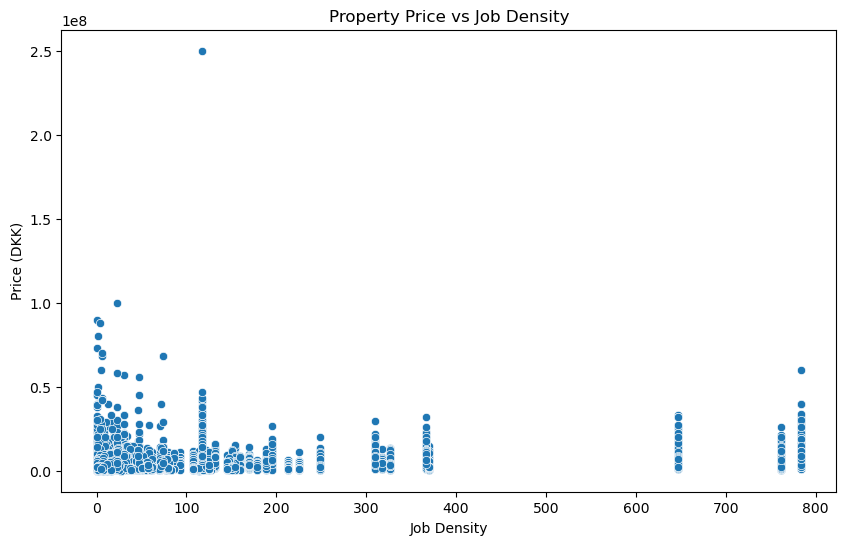

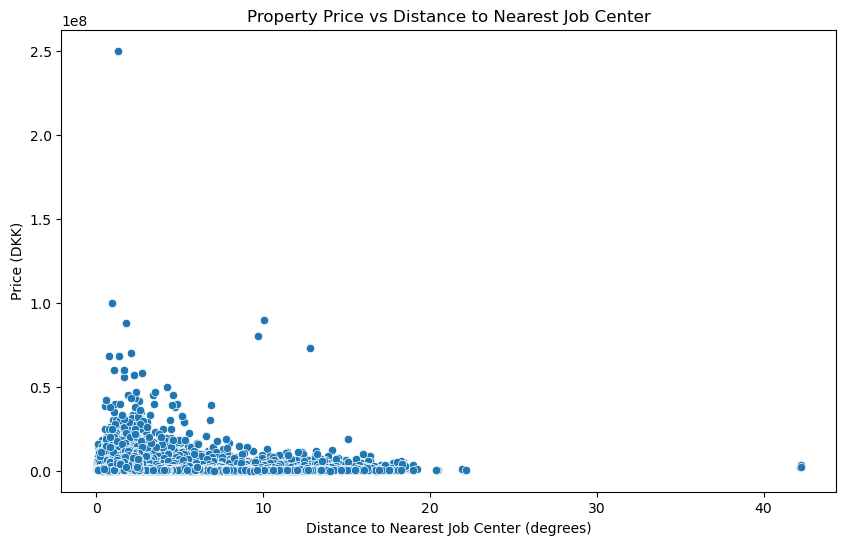

In [109]:
# Scatter plot of priceCash vs job_density
plt.figure(figsize=(10, 6))
sns.scatterplot(x='job_density', y='priceCash', data=ml_dataset)
plt.title("Property Price vs Job Density")
plt.xlabel("Job Density")
plt.ylabel("Price (DKK)")
plt.show()

# Scatter plot of priceCash vs distance_to_job_center
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_job_center', y='priceCash', data=ml_dataset)
plt.title("Property Price vs Distance to Nearest Job Center")
plt.xlabel("Distance to Nearest Job Center (degrees)")
plt.ylabel("Price (DKK)")
plt.show()


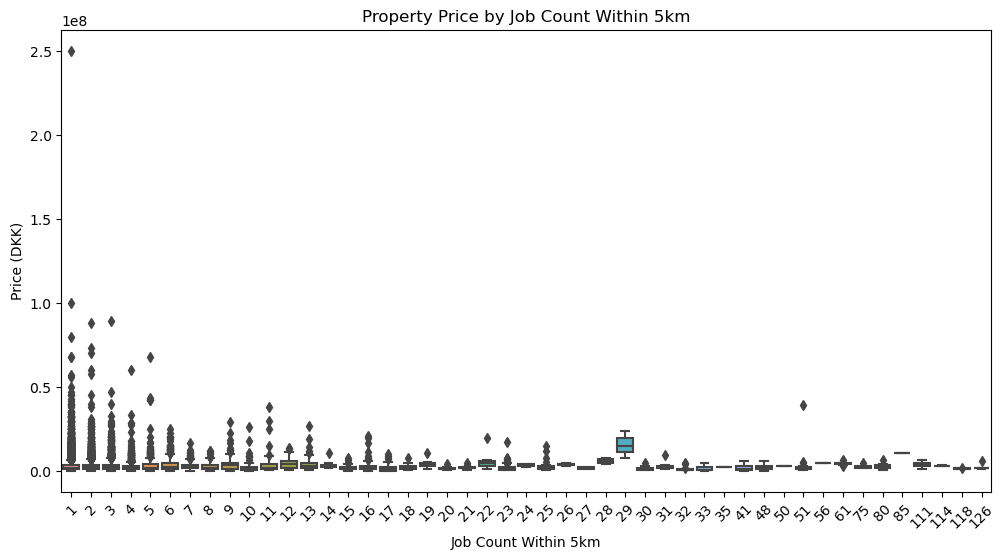

In [110]:
# Boxplot of priceCash by job_count_5km category
plt.figure(figsize=(12, 6))
sns.boxplot(x='job_count_5km', y='priceCash', data=ml_dataset)
plt.title("Property Price by Job Count Within 5km")
plt.xlabel("Job Count Within 5km")
plt.ylabel("Price (DKK)")
plt.xticks(rotation=45)
plt.show()


<Figure size 1200x1000 with 0 Axes>

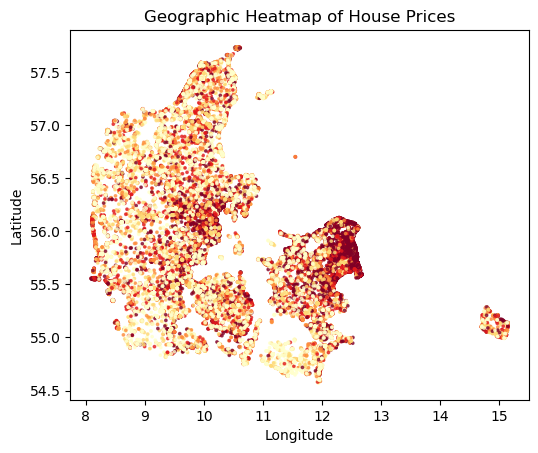

In [111]:
# Plotting the geographic heatmap of house prices with smaller markers
plt.figure(figsize=(12, 10))
real_estate_with_density.plot(
    column='priceCash', 
    cmap='YlOrRd', 
    scheme='quantiles', 
    legend=False,
    markersize=3,  # Reduce the marker size
    alpha=0.7  # Add transparency
)
plt.title("Geographic Heatmap of House Prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1200x1000 with 0 Axes>

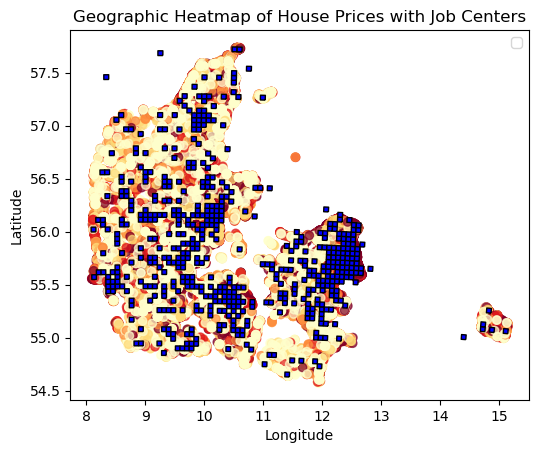

In [112]:

# Create the base map with the geographic heatmap of house prices
plt.figure(figsize=(12, 10))
base = real_estate_with_density.plot(
    column='priceCash', 
    cmap='YlOrRd', 
    scheme='quantiles', 
    legend=True,
    alpha=0.7  # Add transparency to the house prices layer
)

# Overlay the job centers on top
job_centers.plot(
    ax=base, 
    color='blue', 
    edgecolor='black', 
    markersize=50, 
    marker='o',  # Use circle marker for job centers
    label='Job Centers'
)

# Add title and labels
plt.title("Geographic Heatmap of House Prices with Job Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

plt.show()


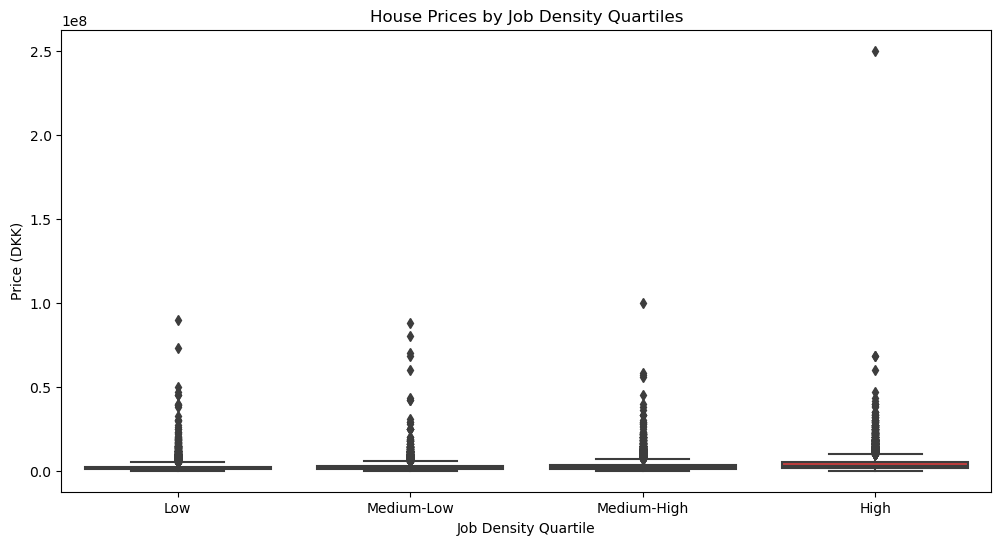

In [113]:
ml_dataset['job_density_quartile'] = pd.qcut(ml_dataset['job_density'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='job_density_quartile', y='priceCash', data=ml_dataset)
plt.title("House Prices by Job Density Quartiles")
plt.xlabel("Job Density Quartile")
plt.ylabel("Price (DKK)")
plt.show()

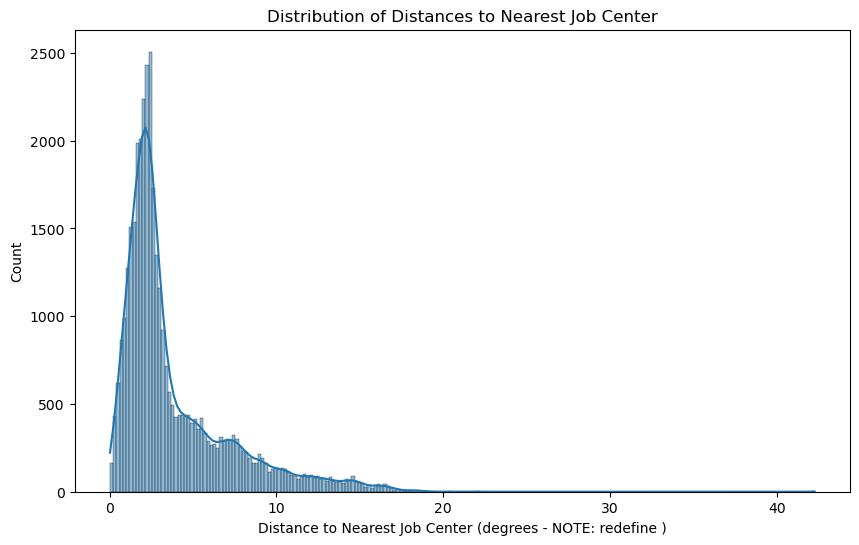

In [114]:
plt.figure(figsize=(10, 6))
sns.histplot(data=ml_dataset, x='distance_to_job_center', kde=True)
plt.title("Distribution of Distances to Nearest Job Center")
plt.xlabel("Distance to Nearest Job Center (kilometers)")
plt.show()

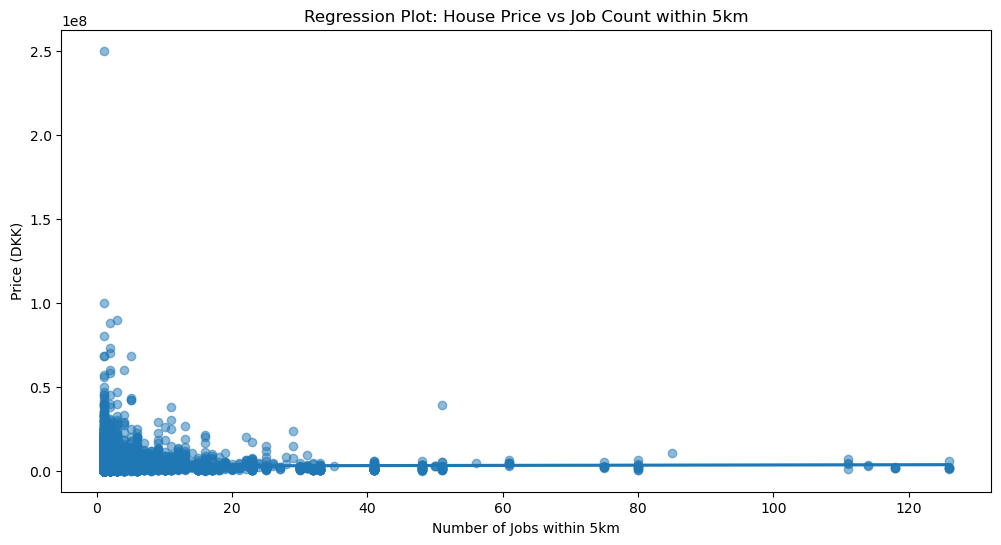

In [90]:
plt.figure(figsize=(12, 6))
sns.regplot(x='job_count_5km', y='priceCash', data=ml_dataset, scatter_kws={'alpha':0.5})
plt.title("Regression Plot: House Price vs Job Count within 5km")
plt.xlabel("Number of Jobs within 5km")
plt.ylabel("Price (DKK)")
plt.show()


In [92]:
# Explore this when we've run our preferred model and have predictions
ml_dataset['residuals'] = ml_dataset['priceCash'] - model.predict(X)

plt.figure(figsize=(12, 10))
real_estate_with_density.plot(
    column='residuals', 
    cmap='RdYlBu', 
    scheme='quantiles', 
    legend=True,
    markersize=3,
    alpha=0.7
)
plt.title("Geographic Distribution of Model Residuals")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

NameError: name 'model' is not defined